In [73]:
import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [75]:
data = pd.read_csv('/Users/boralim/Desktop/capstone/crawling_naver_iphone.csv', encoding='utf-8')
#column name: description
description = list(data.description)

In [240]:
#구두점 및 특수문자 제거
from string import punctuation
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

#한글, 영문, 숫자만 남기고 제거
def clean_text(text): 
    text = text.replace(".", " ").strip() 
    text = text.replace("·", " ").strip()
    text = text.replace("b", " ").strip()
    text = re.sub('[^ㄱ-ㅣ가-힣|0-9|a-zA-Z]+', repl=' ', string=text) 
    return text

In [241]:
clean_description=[]
for sentance in description:
    result = strip_punctuation(sentance)
    result = clean_text(result)
    clean_description.append(result)

In [ ]:
#의미 없는 단어 제거
no_keyword=['아이폰12', '아이폰11', '아이폰 12', '아이폰 11', '12', '11', 'iPhone12']

In [242]:
clean_description

['애플의 첫 5G폰 iPhone 12 시리즈 중에서 아이폰12 PRO는 초반 출시 당시에는 재고를 구하기가 어려웠을 두서 없게 썼는데 제 글이 도움이 많이 되었으면 좋겠네요ㅎㅎ gtgtgt 아이폰 특가전 보러가기',
 'iPhone 12 퍼플 리뷰 부제 내가 보려고 기록해 놓는 갑작스럽게 폰을 바꾸게 됐다 2017년도 출처 Youtu e 잇섭 위 아이폰12 프로 퍼시픽블루 아래왼쪽에서부터 아이폰11퍼플 아이폰12 퍼플',
 '애플은 매년 9월 아이폰 신제품을 공개합니다 작년의 경우 코로나 19로 인해 9월이 아닌 10월에 그 중 하나가 바로 아이폰12 퍼플입니다 기존에 나왔던 iPhone 12 미니와 iPhone 12에는 블루 그린 블랙',
 '이런 관점에서 아이폰 11 Pro Max와 12Pro Max 두 모델의 스펙을 비교해봤습니다 위의 표를 보면 한 눈에 물론 세부적인 사항을 살펴보면 아무래도 아이폰 12 Pro Max의 손을 들어줄 수 밖에 없지만 브이로그',
 '얼른 시간이 가길 바라는 마음으로 아이폰12 를 구매하고자 하는 분들이 늘어나고 있는 추세입니다 저 역시 최근에 아이폰12 를 사면서 이런 곳이 있다는 것에 다시 한번 놀랄 수밖에 없었는데요 경험한',
 '누나가 아이폰12 미니 쓰고 내가 누나꺼 쓸께 YES 기회다 싶어 동생이랑 폰 바꿨어요 ㅋㅋㅋ 원래 동생도 아이폰13 나오면 바꾸려다 제가 12프로맥스 야무지게 넘겨 받았어요 물론 사용감도 없이 한번도 안',
 'CHOETECH 저도 몇 개월 전 애플워치와 아이폰 에어팟 동시 충전되는 제품을 써보고 좋아서 친구에게 정품 아니지만 자력 괜찮은 편 저는 아이폰 12 프로 유저인데 두꺼운 그립 톡이 붙은 스마트폰',
 '5배 광학 줌인과 5배 광학 줌 업위에 최대 12배 디지털 줌을 지원하거든요 크기와 무게까지 감안하면 PRO 모델이 더 좋다고 생각하지만 이는 사람마다 다르겠죠 지금 아이폰12 PRO 가격은 공시지원금이',
 '전작 iPhone 11시리즈는 일반 프로 프로맥스 3가지로 나왔던 반

In [243]:
from konlpy.tag import Kkma
kkma = Kkma() #형태소 분석기

dataset=[]
for i in range(len(clean_description)):
    dataset.append(kkma.nouns(re.sub('[^가-힣|0-9|a-zA-Z]+', '', clean_description[i])))

In [244]:
#불용어 제거
stopwords_file = open("한국어불용어100.txt", "r")
stop_words = []
for line in stopwords_file.readlines():
    stop_words.append(line)
stopwords_file.close()

dataset_without_stopwords=[]
for w in dataset:
    if w not in stop_words:
        dataset_without_stopwords.append(w)

In [245]:
from gensim import corpora, models
from gensim.models import CoherenceModel
import gensim
import matplotlib.pyplot as plt

In [246]:
#데이터를 dictionary 형태로 명사 리스트 만들기
dataset2=dataset_without_stopwords
dataset2=[[y for y in x if not len(y)==1] for x in dataset2]

#정수 인코딩과 빈도수 생성
dictionary=corpora.Dictionary(dataset2)

#출현빈도가 적거나 자주 등장하는 단어는 제거
dictionary.filter_extremes(no_below=10, no_above=0.05)
corpus=[dictionary.doc2bow(text) for text in dataset2]
print('Number of unique tokens: %d' % len(dictionary)) 
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 232
Number of documents: 1000


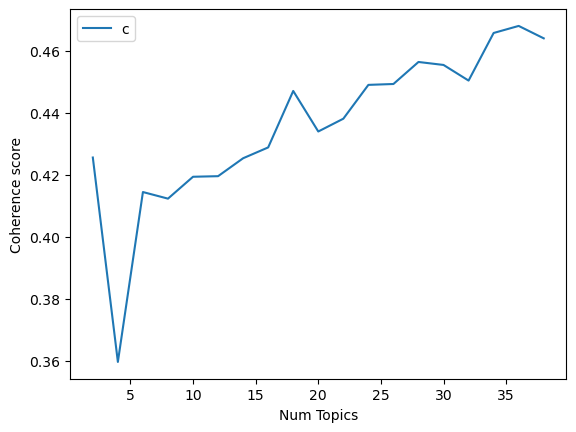

In [247]:
# 최적의 토픽 수 찾기 
#CoherenceModel을 통한 토픽 최적화: 토픽이 얼마나 의미론적으로 일관성 있는지 판단. 높을수록 의미론적 일관성 높음
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = [] 
    model_list = [] 
    for num_topics in range(start, limit, step): 
        model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics) 
        model_list.append(model) 
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v') 
        coherence_values.append(coherencemodel.get_coherence()) 
    return model_list, coherence_values

def find_optimal_number_of_topics(dictionary, corpus, processed_data): 
    limit = 40; 
    start = 2; 
    step = 2; 
    
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step) 
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence_values"), loc='best') 
    plt.show()

find_optimal_number_of_topics(dictionary, corpus, dataset2)

In [259]:
ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=6, alpha=0.1, id2word=dictionary)

topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.046*"강화" + 0.042*"강화유리" + 0.018*"충전" + 0.018*"세이프" + 0.017*"12프로"')
(1, '0.024*"럭시" + 0.019*"12프로" + 0.015*"컬러" + 0.015*"비교" + 0.015*"아이폰11"')
(2, '0.021*"12시리즈" + 0.021*"기종" + 0.014*"아이폰12케이스" + 0.014*"아래" + 0.014*"스펙"')
(3, '0.035*"크기" + 0.027*"기존" + 0.025*"오늘" + 0.017*"화이트" + 0.016*"케이스아이"')
(4, '0.025*"느낌" + 0.022*"케이스아이폰12" + 0.017*"충전" + 0.016*"블루" + 0.016*"최근"')
(5, '0.032*"사전" + 0.031*"예약" + 0.029*"컬러" + 0.021*"10" + 0.015*"부분"')


In [260]:
# Compute Coherence Score using c_v 0.55정도가 준수
coherence_model_lda = CoherenceModel(model=ldamodel, texts=dataset2, dictionary=dictionary, coherence='c_v') 
coherence_lda = coherence_model_lda.get_coherence() 
print('\nCoherence Score (c_v): ', coherence_lda) 

# Compute Coherence Score using UMass 0에 가까울수록 완벽한 일관성
coherence_model_lda = CoherenceModel(model=ldamodel, texts=dataset2, dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence() 
print('\nCoherence Score (u_mass): ', coherence_lda)


Coherence Score (c_v):  0.4316360382721729

Coherence Score (u_mass):  -12.486622734622886


In [261]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.039321 -0.031691       1        1  18.768464
1     -0.035275 -0.033024       2        1  17.242898
4      0.069702 -0.005156       3        1  17.074322
5      0.054173  0.076784       4        1  16.767655
2     -0.030791 -0.066181       5        1  15.193248
0     -0.097130  0.059269       6        1  14.953414, topic_info=     Term       Freq      Total Category  logprob  loglift
90     강화  49.000000  49.000000  Default  30.0000  30.0000
91   강화유리  40.000000  40.000000  Default  29.0000  29.0000
59     사전  32.000000  32.000000  Default  28.0000  28.0000
60     예약  33.000000  33.000000  Default  27.0000  27.0000
43     크기  47.000000  47.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
94   폰케이스   6.207107  31.231782   Topic6  -4.6892   0.2845
106   휴대폰   6.207075  31.716147   Topic6  -4.6892   0.2691
181    부분   5.200631  28.339457   Topic6  -4.8661   0.2048
75     가능   5.200539  32.428034   Topic6  -4.8662   0.0700
121    무선   5.200469  20.455065   Topic6  -4.8662   0.5307

[309 rows x 6 columns], token_table=      Topic      Freq Term
term                      
231       1  0.142900   03
231       2  0.071450   03
231       3  0.142900   03
231       4  0.500151   03
231       6  0.071450   03
...     ...       ...  ...
209       2  0.221160   힐링
209       3  0.147440   힐링
209       4  0.073720   힐링
209       5  0.147440   힐링
209       6  0.294880   힐링

[997 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 6, 3, 1])